In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import itertools

from deepsphere import utils

plt.rcParams['figure.figsize'] = (17, 5) # for matplotlib notebook

nside = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

# 1) ANAFAST: what is it?
Execution of anafast requires a user to specify the maximum spherical harmonic order  $\ell_{\mathrm{max}}$ up to which the harmonic decomposition of the input maps will be performed. Since there are no formal limits on parameter  $\ell_{\mathrm{max}}$ enforced by anafast, the user should make his/her choices judiciously. Hereafter it is convenient to specify  $\ell_{\mathrm{max}}$ in terms of the HEALPix map resolution parameter Nside (called nsmax in some other contexts). 

If the function to be analysed is strictly band-width limited, or nearly band-width limited (as in the case of a Gaussian beam smoothed signal discretized at a rate of a few pixels per beam area), it is sufficient to run anafast with  $\ell_{\mathrm{max}}\approx 2\cdot N_{\mathrm{side}}$, with a very good $C_\ell$ error performance already in the raw (i.e. uncorrected quadrature) harmonic transform mode. If quadrature corrections are still desired in this case, it should be sufficient to use, at no extra cost in execution time, the ring-weighted quadrature scheme. This is the recommended mode of operation of anafast for essentially error and worry free typical applications, e.g. CPU-intensive Monte Carlo studies. 

A new set of pixel-based quadrature weights was introduced in HEALPix 3.40. Pre-computed to inforce a (near) ideal integration of the spherical harmonics $Y_{\ell m}$ on the pixelized sphere (ie  $\frac{4\pi}{N_{\mathrm{pix}}} \sum_p w(p) Y_{\ell m}(p) = \sqrt{4 \pi} \delta_{\ell 0}\delta_{m 0}$) for  $\vert m\vert \le \ell \le 3 N_{\mathrm{side}}$, they can be used to insure that the $a_{\ell m}$ and $C_\ell$ computed by anafast are perfectly accurate (almost to machine precision) without the need for iterations, but only for band-width limited input signal with  $\ell_{\mathrm{max}}\le 1.5 N_{\mathrm{side}}$. 

If more aggressive attempts are undertaken to extract from a map the spectral coefficients at  $\ell > 2\cdot N_{\mathrm{side}}$ (for example, as in a possible case of an attempt to analyse an existing map, which was irreversibly binned at a suboptimal resolution) the following should be kept in mind: 

$\bullet$ __Spherical harmonics discretized using HEALPix (either sampled at pixel centers, or avaraged over pixel areas) form a linearly independent system up to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$. Hence, the functions which are strictly band-width limited to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$ can be fully spectrally resolved with anafast, albeit with integration errors in the uncorrected quadrature mode__, which grow up to  $\delta C_\ell \propto \epsilon \cdot C_\ell$, with $\epsilon <0.1$, at the highest values of $\ell$. These integration errors can be efficiently reduced using anafast in the iterative mode. Although this  $\ell_{\mathrm{max}}$ range --  $2 \cdot N_{\mathrm{side}}< \ell_{\mathrm{max}}< 3 \cdot N_{\mathrm{side}}- 1$ -- is easily manageable with anafast used on strictly band-width limited functions, it should be used with caution in basic and automated applications, e.g. Monte Carlo simulations. 

$\bullet$ __As with any discrete Fourier transform, anafast application to functions which are not band-width limited results with aliasing of power, which can not be remedied__. If the particular case of interest may result in such a band-width violation (i.e. there is significant power in the function at  $\ell > 3 \cdot N_{\mathrm{side}}-1$), the function should be smoothed before the application of anafast, or discretized and then analysed, on a refined HEALPix grid (with larger Nside). 

$\bullet$ REMEMBER: A peculiar property of the sphere, which usually surprises those whose intuition is built on experience with FFTs on a segment, or on a Euclidean
multidimensional domain, is the lack of a regular and uniform point-set at arbitrary resolution, and the resulting __non-commutativity of the forward and backward discrete Fourier transforms__ on nearly-uniform point-sets, e.g. HEALPix. Hence, as in any case of attempting an extreme application of an off-the-shelf software, use caution and understand your problem well before executing anafast under such circumstances!



### Let's do a check to evaluate how many iterations of Anafast we need to have a decent integration of the first $\ell_\max < 3\cdot N_{side}-1$ spherical harmonics

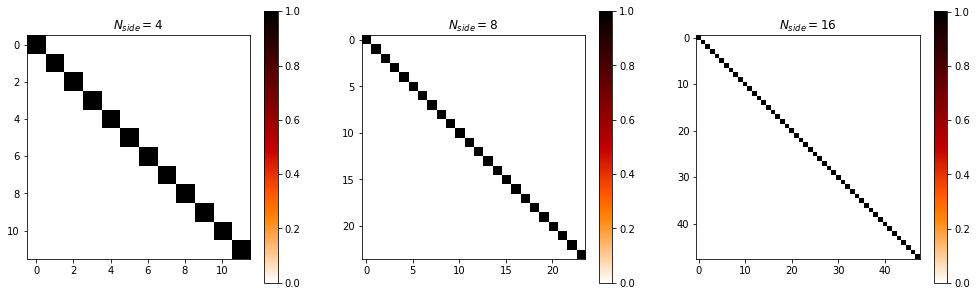

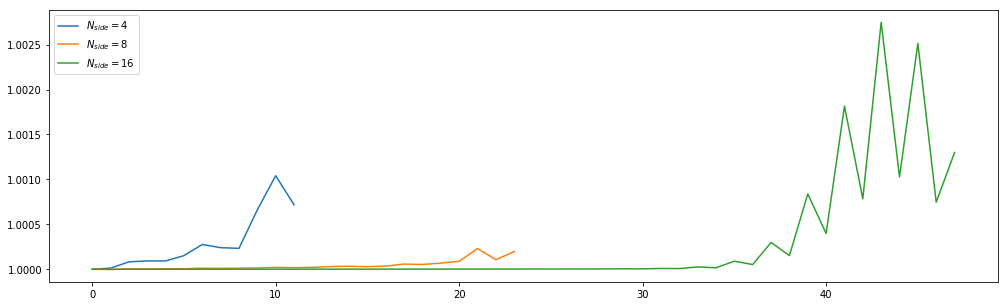

In [32]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1
    
    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    n_harmonics = harmonics.shape[1]
    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        harmonic = hp.reorder(harmonics[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();



### Conclusions
8 iterations of anafast bring an error of less of 0.2%, it seems acceptable for our purpose

# 2) How to set $\sigma(N_{side})$

Let's plot the histogram of the distances between pixels for the following values of $N_{side}=\{4,8,16,32\}$.
We hope to see a peak close to $0$, meaning that the first neighbors of a node are in a specific range of distance. 

__Remark:__ HEALPix sampling is made such that at each pixel is associated equal area, but distances between pixels are not regular!

Once identified the distance $\bar d$ corresponding to the peak closest to $0$, we set $\sigma=\bar d$

### 2.1) $N_{side}=1 \implies \sigma=0.1$

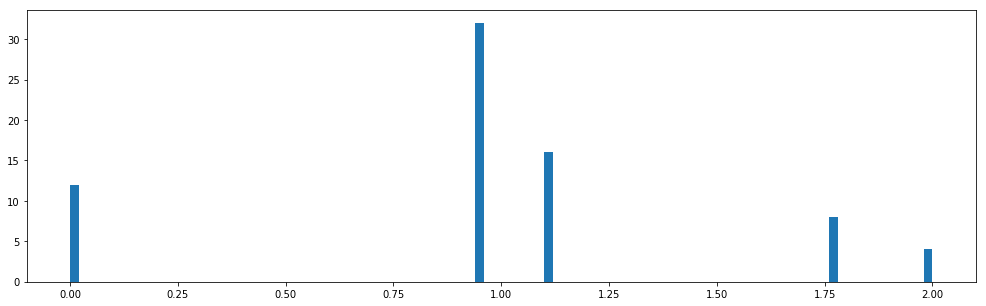

In [38]:
utils.full_healpix_weightmatrix(nside=1, dtype=np.float32, std=0.005, plot=True, max_plot=2);
plt.savefig('06_figures/hist_1')

### $N_{side}=2 \implies \sigma=0.3$

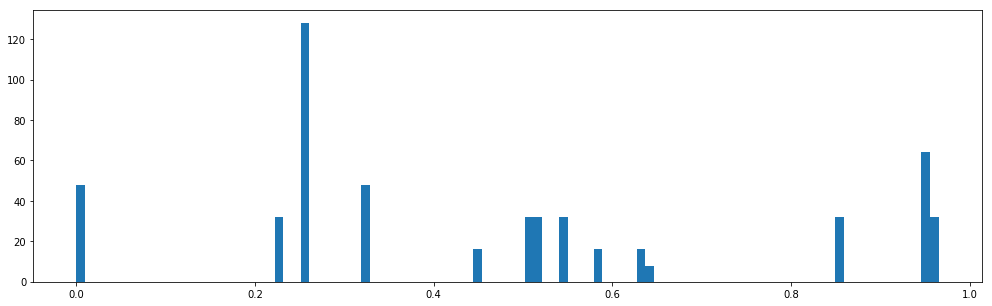

In [40]:
utils.full_healpix_weightmatrix(nside=2, dtype=np.float32, std=0.005, plot=True, max_plot=1);
plt.savefig('06_figures/hist_2')

### $N_{side}=4 \implies \sigma=0.1$

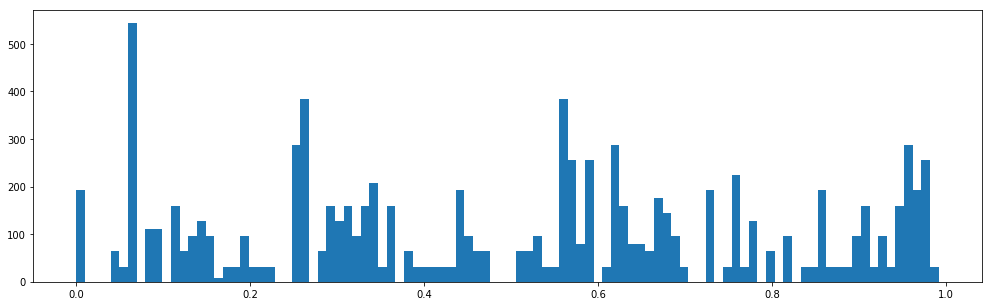

In [41]:
utils.full_healpix_weightmatrix(nside=4, dtype=np.float32, std=0.005, plot=True, max_plot=1);
plt.savefig('06_figures/hist_4')

### 2.2) $N_{side}=8 \implies \sigma=0.025$

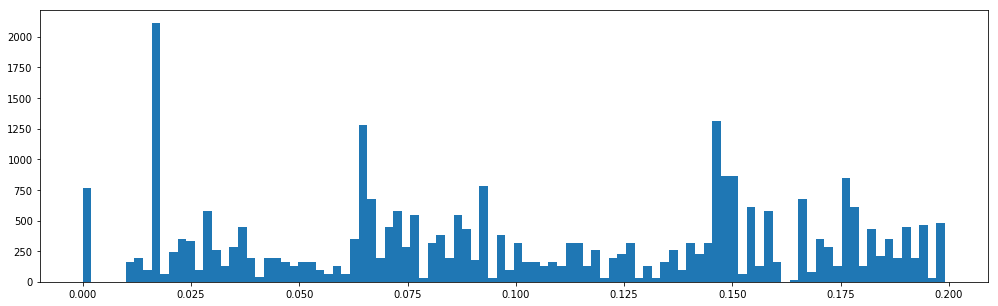

In [34]:
utils.full_healpix_weightmatrix(nside=8, dtype=np.float32, std=0.005, plot=True, max_plot=0.2);

### 2.3) $N_{side}=16 \implies \sigma=0.01$

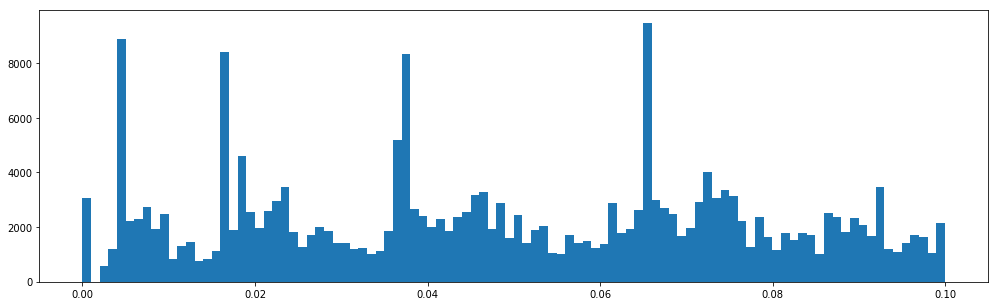

In [35]:
utils.full_healpix_weightmatrix(nside=16, dtype=np.float32, std=0.01, plot=True, max_plot=0.1);

### 2.4) $N_{side}=32 \implies \sigma=0.002$

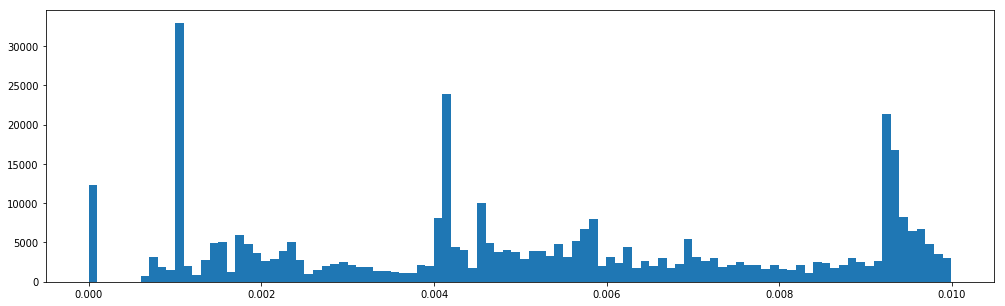

In [36]:
utils.full_healpix_weightmatrix(nside=32, dtype=np.float32, std=0.005, plot=True, max_plot=0.01);

### Conclusions:
| $N_{side}$| $\sigma$ |     
|-----------|:--------:|
| 1         | 1      |
| 2         | 0.3    |
| 4         | 0.1    |
| 8         | 0.025  |
| 16        | 0.01   |
| 32        | 0.002  |

### 2.5) Let's try to see how the eigenspaces of the graph laplacian of a full graph look like, with $\sigma(N_{side})$ set accordingly to the table 

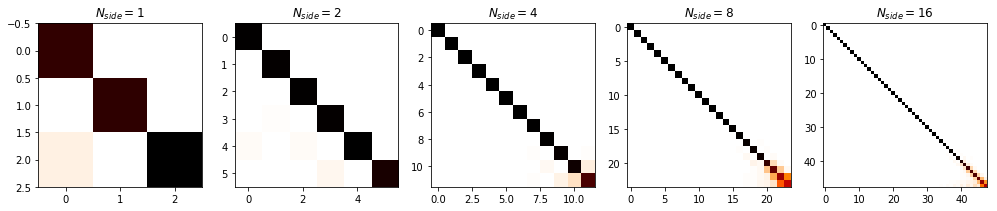

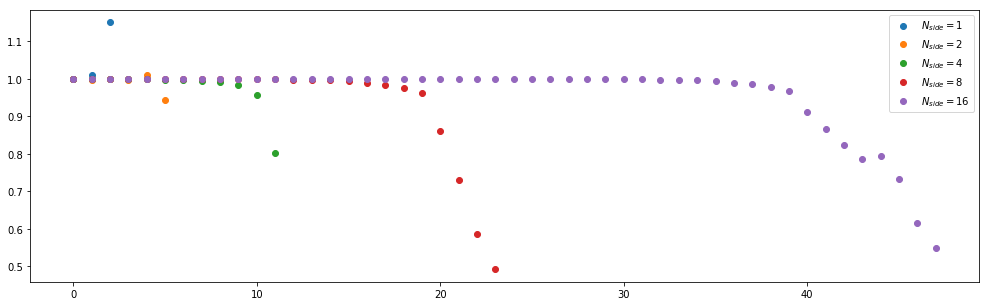

In [18]:
nsides = [1, 2, 4, 8, 16]
sigmas = [1., 0.3, 0.1, 0.025, 0.01]
graphs = []
spectral_content = dict()

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();


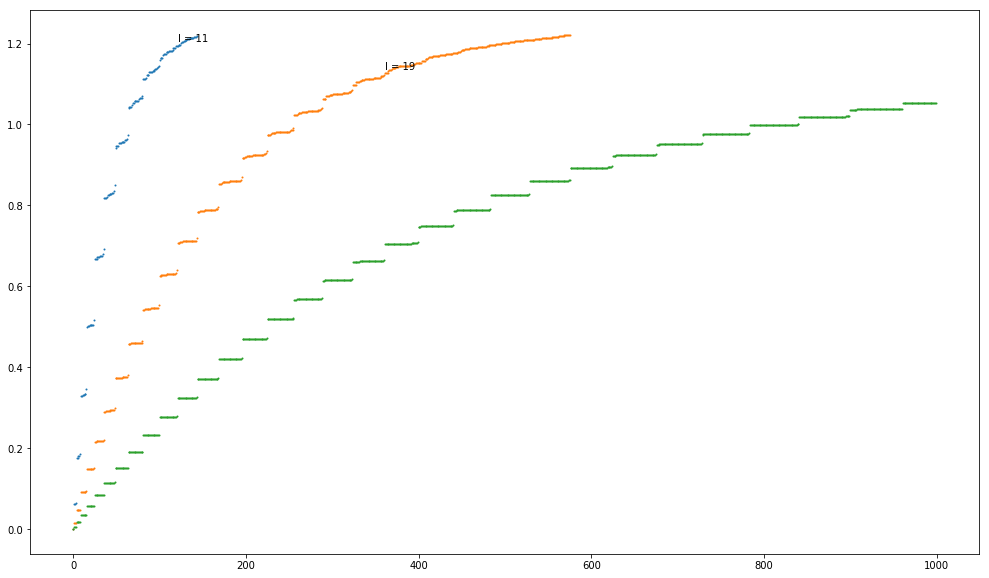

In [55]:
plt.rcParams['figure.figsize'] = (17, 10)
for graph in graphs[:3]:
    plt.plot(graph.e[:1000], 'o', markersize=1)

l = 11
idx = l**2
plt.text(idx, graphs[0].e[idx] + 0.01, 'l = {}'.format(l));


l = 19
idx = l**2
plt.text(idx, graphs[1].e[idx] + 0.01, 'l = {}'.format(l));


We can see how the point where the Graph Laplacian eigenspaces get disaligned with the eigenspaces of the continuous operator $\triangle$ correspond to the point where there's no gap anymore in the eigenvalues.

### Conclusions:
the improvement with respect to the results shown in [1] are huge.
![Energy of each eigenspace](05_figs/old_results2.png)
*Old DeepSphere results: energy of each eigenspace*
![Eigenvalues](05_figs/old_results3.png)
*Old DeepSphere results: Eigenvalues for $N_{side}=16$*

However, __remember that here we have a full graph__. However, because of the exponential decay of the gaussian kernel we expect by truncating the weights (sparsifying the graph) to obtain very similar results. Let's try:

# 3) Sparsifying the graphs

we threshold the __full__ weight matrix at a fixed threshold of $k=0.01$.

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01
Number of neighbours:  21.291666666666668
Threshold:  0.01
Number of neighbours:  21.28125
Threshold:  0.01
Number of neighbours:  35.3515625


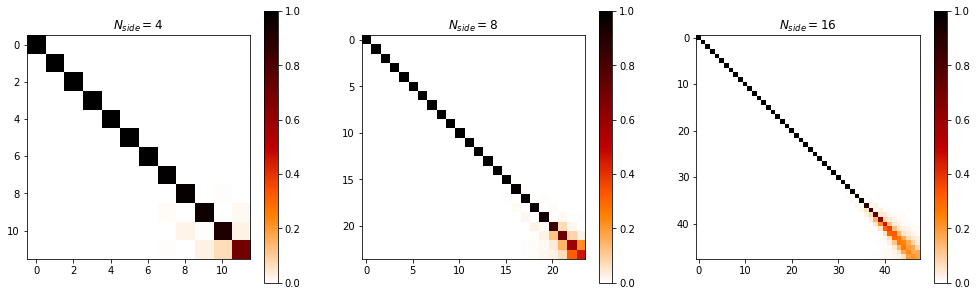

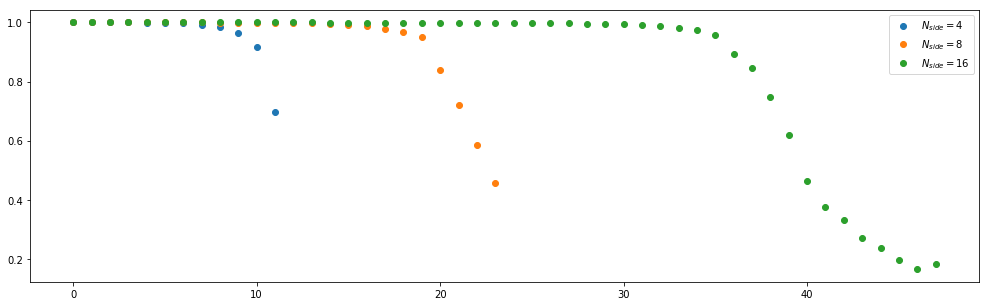

In [45]:
plt.rcParams['figure.figsize'] = (17, 5)
nsides = [4, 8, 16]
sigmas = [0.1, 0.025, 0.01]

spectral_content = dict()

k = 0.01
 
for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    graphs.append(pg.graphs.Graph(W))
    graph = graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

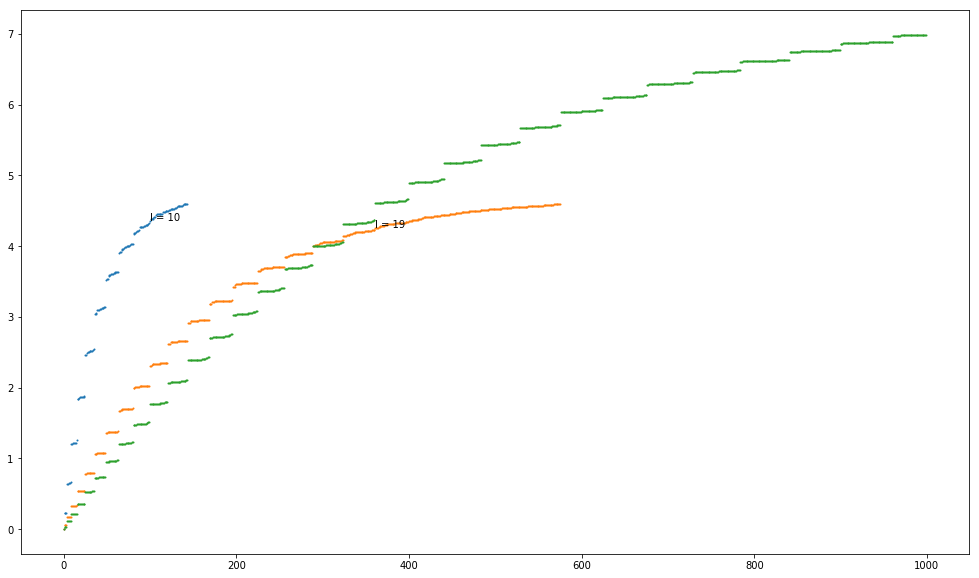

In [59]:
plt.rcParams['figure.figsize'] = (17, 10)
for graph in graphs[3:]:
    plt.plot(graph.e[:1000], 'o', markersize=1)

    
l = 10
idx = l**2
plt.text(idx, graphs[3].e[idx] + 0.01, 'l = {}'.format(l));


l = 19
idx = l**2
plt.text(idx, graphs[4].e[idx] + 0.01, 'l = {}'.format(l));



# 4) Finer analysis on $\sigma(N_{side})$

### 4.0) $N_{side}=1$

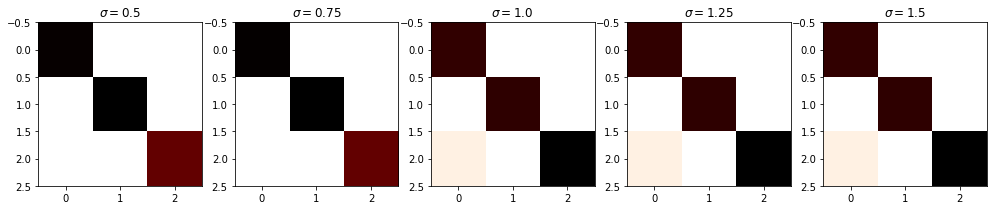

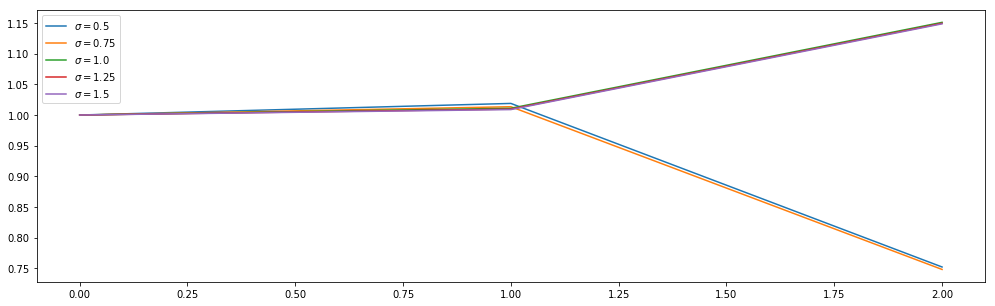

In [55]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.linspace(0.5,1.5,5)
nsides = [1]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$\sigma={sigma}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();

### 4.1) $N_{side}=2$

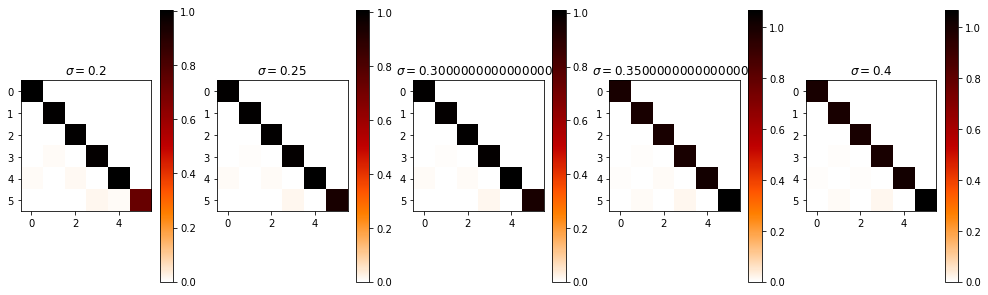

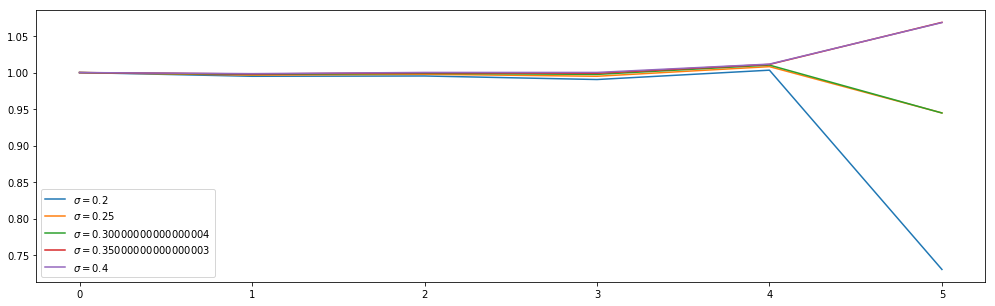

In [6]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.linspace(0.2,0.4,5)
nsides = [2]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();

### 4.1) $N_{side}=4$

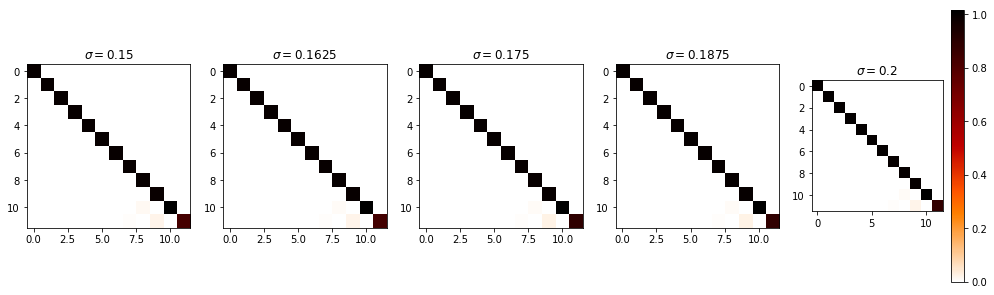

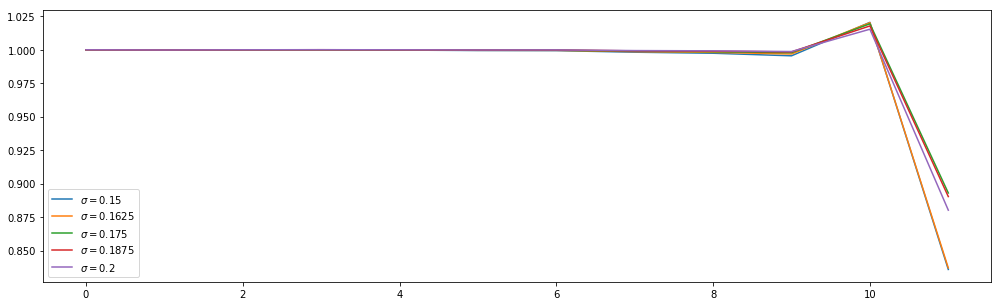

In [45]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.linspace(0.15,0.2,5)
nsides = [4]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    # fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')
fig1.colorbar(im, ax=ax)
ax2.legend();

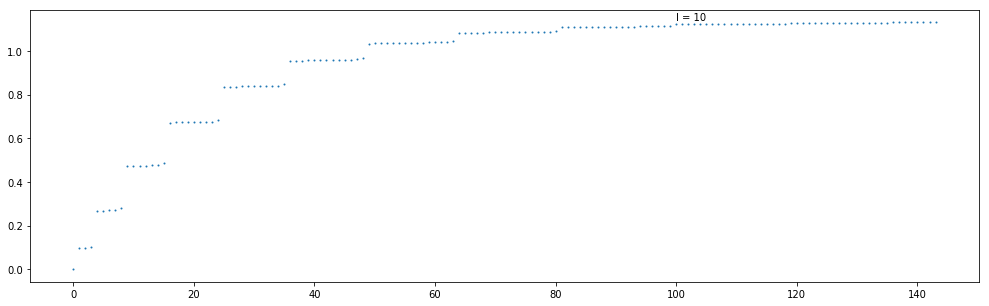

In [98]:
plt.plot(graphs[2].e[:1000],'o',  markersize=1)


l = 10
idx = l**2
plt.text(idx, graphs[1].e[idx] + 0.01, 'l = {}'.format(l));

### 4.2) $N_{side}=8$

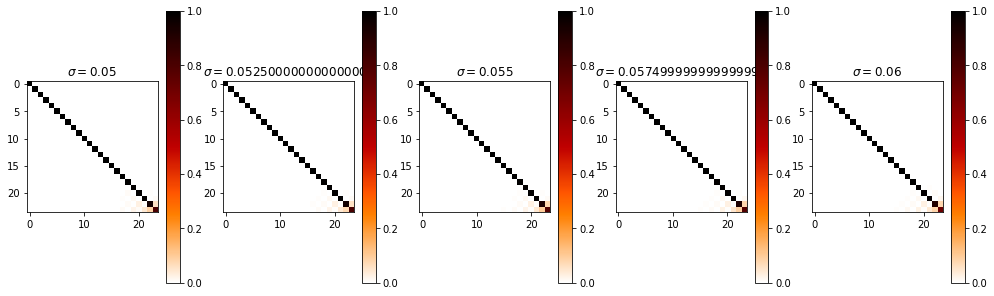

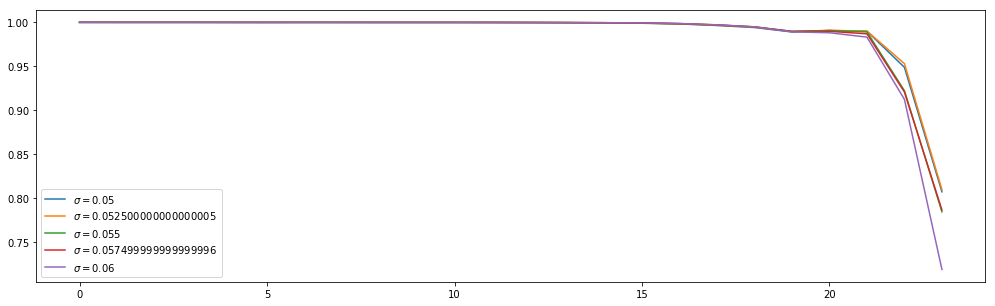

In [90]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.linspace(0.05,0.06,5)
nsides = [8]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    # fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();

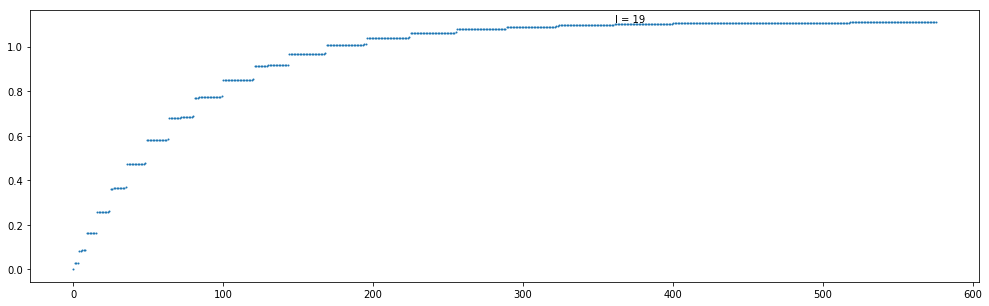

In [91]:
plt.plot(graphs[1].e[:1000], 'o', markersize=1)


l = 19
idx = l**2
plt.text(idx, graphs[1].e[idx] + 0.01, 'l = {}'.format(l));

### $N_{side}=16$

In [42]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.linspace(0.012,0.018,3)
nsides = [16]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    #fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();

KeyboardInterrupt: 

We conclude that for a full graph the best sigma is the following table:

### Conclusions:
| $N_{side}$| $\sigma$ |     
|-----------|:--------:|
| 1         | 1      |
| 2         | 0.3    |
| 4         | 0.175    |
| 8         | 0.0525  |
| 16        | 0.015   |
| 32        | 0.004  |


# ANALYSIS ON THE SPEED OF CONVERGENCE OF SPARSE GRAPHS, FIXED $\sigma$ AND $N_{side}$

Let's try to see what happens to the convergence of the healpix graph fixed the number of neighbors to 7-8 (as in DeepSphere)

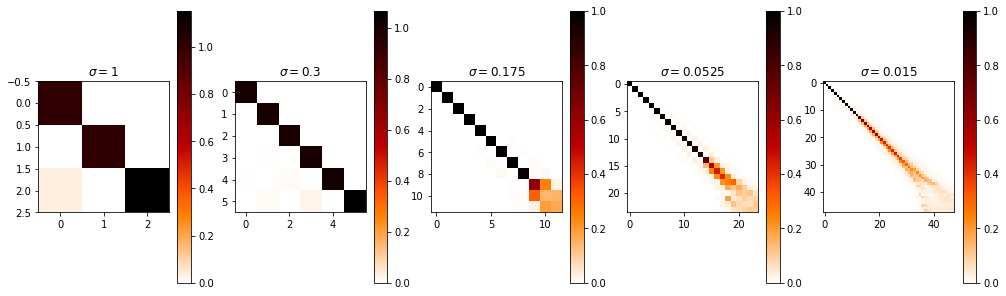

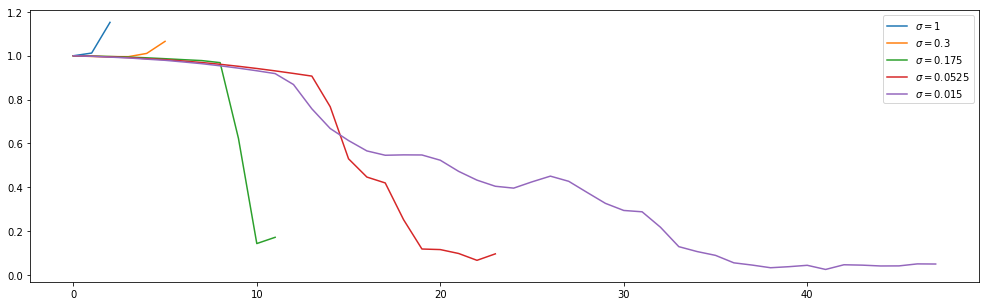

In [14]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]
nsides = [1, 2, 4, 8, 16]

healpix_graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    healpix_graphs.append(utils.healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = healpix_graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();

Let's try with a fixed __threshold__ 

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01
Number of neighbours:  11.0
Threshold:  0.01
Number of neighbours:  16.833333333333332
Threshold:  0.01
Number of neighbours:  37.708333333333336
Threshold:  0.01
Number of neighbours:  43.510416666666664
Threshold:  0.01
Number of neighbours:  52.6171875


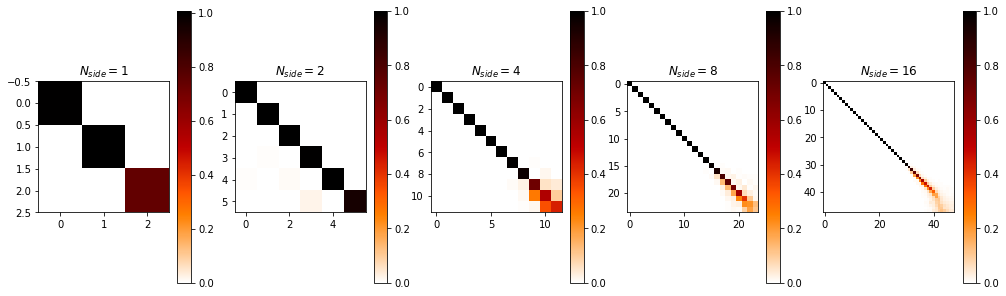

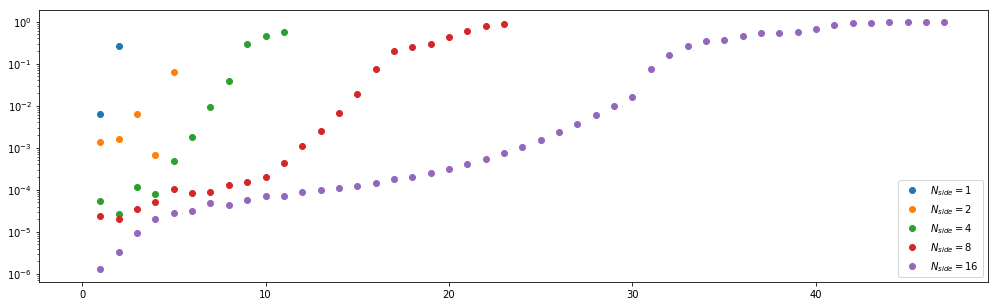

In [39]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]
nsides = [1, 2, 4, 8, 16]

thresholded_graphs = []
spectral_content = dict()

k = 0.01
 
for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    thresholded_graphs.append(pg.graphs.Graph(W))
    graph = thresholded_graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.semilogy(abs(1-energy_in), 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

### Conclusions:
even with a fixed threshold we keep improving accuracy even on the low frequencies!

## Let's try with a higher (and fixed) number of neighbors to have a confirmation that it doesn't work

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.0001
Number of neighbours:  11.0
Threshold:  0.02
Number of neighbours:  14.166666666666666
Threshold:  0.17
Number of neighbours:  14.708333333333334
Threshold:  0.22
Number of neighbours:  14.71875
Threshold:  0.28
Number of neighbours:  14.346354166666666


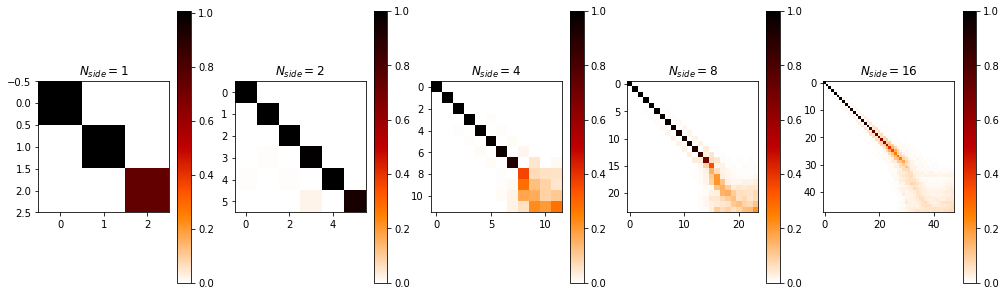

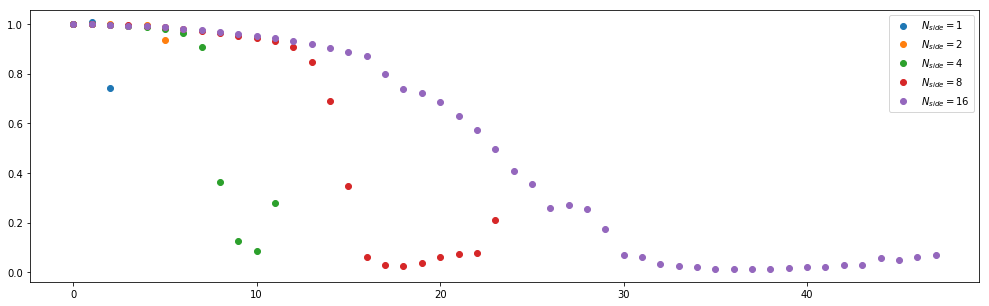

In [36]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]
nsides = [1, 2, 4, 8, 16]

thresholded_graphs = []
spectral_content = dict()

kappas = [0.0001, 0.02, 0.17, 0.22, 0.28]

 
for nside, sigma, k in zip(nsides, sigmas, kappas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    thresholded_graphs.append(pg.graphs.Graph(W))
    graph = thresholded_graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

### Comments
We see that to keep the number of neighbors constant we are increasing the threshold, meaning we are doing worse and worse approximations of the continuous operator $L^t$

# BETTER MEASURE THE ERROR ON LOW FREQUENCIES:

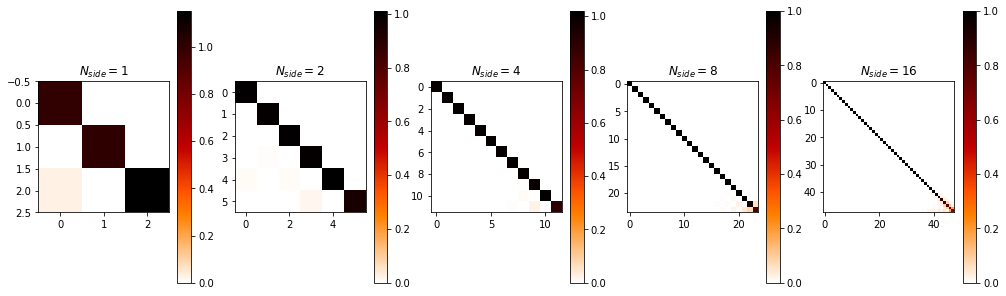

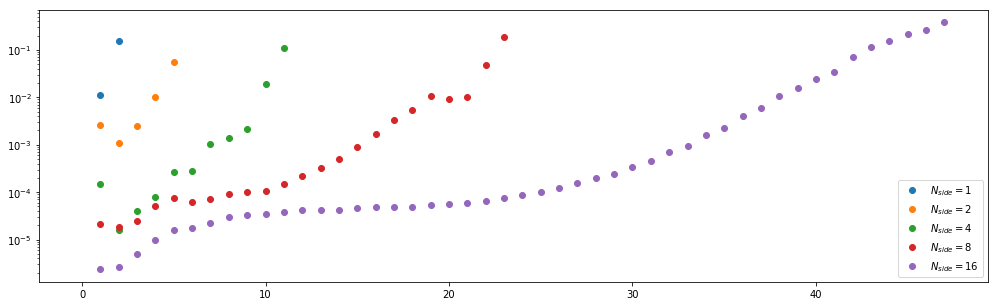

In [38]:
nsides = [1, 2, 4, 8, 16]
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]
graphs = []
spectral_content = dict()

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.semilogy(abs(1-energy_in), 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

### Conclusions
We see that with this sigma we get better both at high and low frequencies!!

# Comparison of $\sigma$ used in DeepSphere and the optimal values found here

In [6]:
utils.healpix_weightmatrix(nside=1, nest=True, indexes=None, dtype=np.float32, std="kernel_width")
utils.healpix_weightmatrix(nside=2, nest=True, indexes=None, dtype=np.float32, std="kernel_width")
utils.healpix_weightmatrix(nside=4, nest=True, indexes=None, dtype=np.float32, std="kernel_width")
utils.healpix_weightmatrix(nside=8, nest=True, indexes=None, dtype=np.float32, std="kernel_width")
utils.healpix_weightmatrix(nside=16, nest=True, indexes=None, dtype=np.float32, std="kernel_width")
utils.healpix_weightmatrix(nside=32, nest=True, indexes=None, dtype=np.float32, std="kernel_width")

kernel width used:  1.3339835
kernel width used:  0.3835359
kernel width used:  0.100323915
kernel width used:  0.025613535
kernel width used:  0.006474086
kernel width used:  0.0016280684


<12288x12288 sparse matrix of type '<class 'numpy.float32'>'
	with 98280 stored elements in Compressed Sparse Row format>

Text(0,0.5,'t')

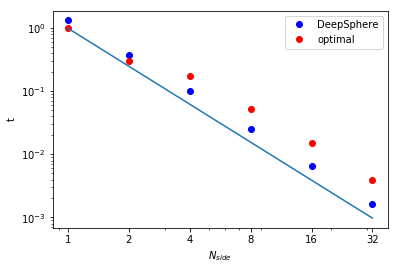

In [8]:
plt.loglog([1,2,4,8,16,32], [1.3339, 0.3835, 0.1003, 0.02561, 0.00647, 0.001628], 'bo', label='DeepSphere')
plt.loglog([1,2,4,8,16,32], [1, 0.3, 0.175, 0.0525, 0.015, 0.004], 'ro', label='optimal')
plt.loglog([1,2,4,8,16,32], [x**(-2) for x in [1,2,4,8,16,32]])
plt.legend()
plt.xticks([1,2,4,8,16,32], [1,2,4,8,16,32])
plt.xlabel('$N_{side}$')
plt.ylabel('t')
# plt.savefig('kernelwidth')

### Conclusions
The behaviour is the same (exponential). We conclude that the fact that was stopping Deferrard et al was mostly the fixed number of neighbors!

Let's get a confirmation of this:

#  ---------------------------------------------
# ------------------ RECAP ------------------
#  ---------------------------------------------

### DeepSphere full graph

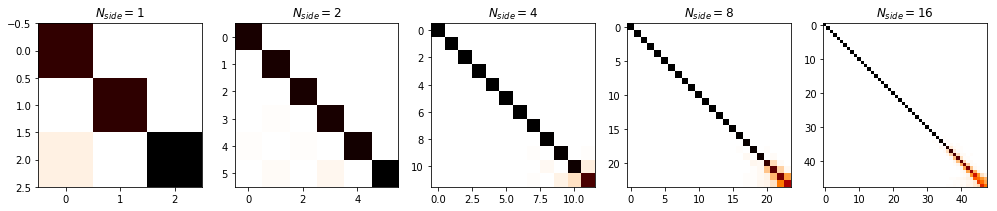

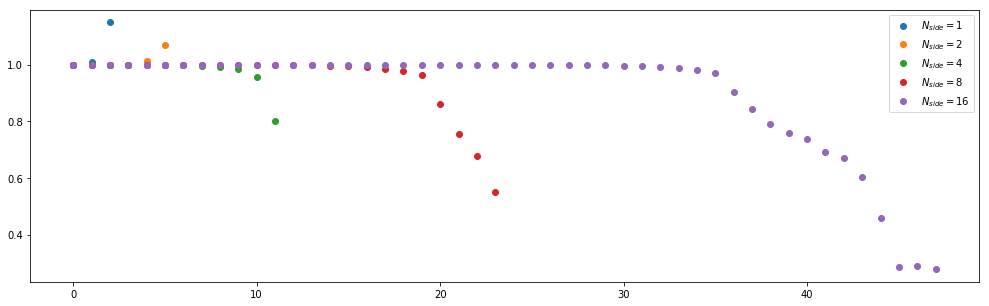

In [7]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [1, 2, 4, 8, 16]
sigmas = [1.3339, 0.3835, 0.1003, 0.02561, 0.00647, 0.001628]
deepsphere_full_graphs = []
spectral_content = dict()

k= 0.01
 
for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    deepsphere_full_graphs.append(graph)
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("deepsphere_full.png")
fig2.savefig("deepsphere_full_diagonal.png")

### DeepSphere thresholded graph

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01
Number of neighbours:  21.291666666666668
Threshold:  0.01
Number of neighbours:  21.447916666666668
Threshold:  0.01
Number of neighbours:  21.7890625


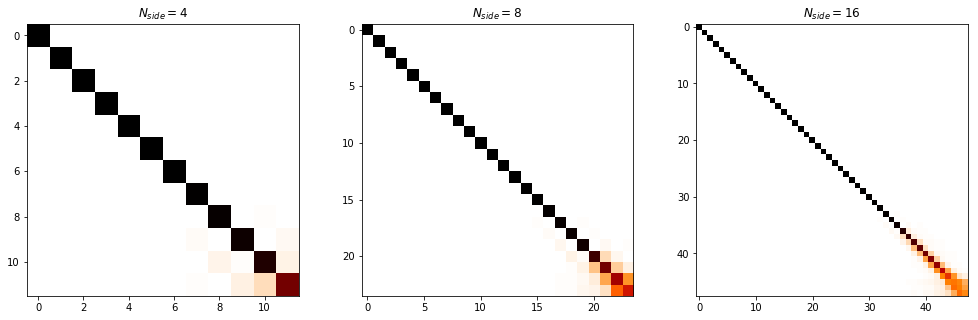

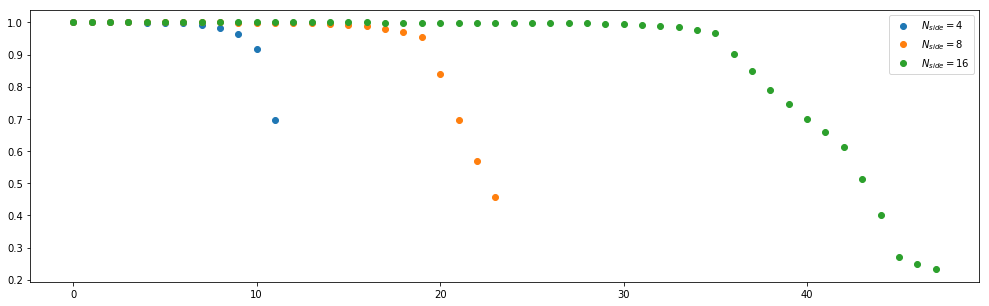

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [4, 8, 16]
sigmas = [0.1003, 0.02561, 0.00647, 0.001628]
deepsphere_thresholded_graphs = []
spectral_content = dict()

k= 0.01
 
for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    deepsphere_thresholded_graphs.append(pg.graphs.Graph(W))
    graph = deepsphere_thresholded_graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("deepsphere_thresholded.png")
fig2.savefig("deepsphere_thresholded_diagonal.png")

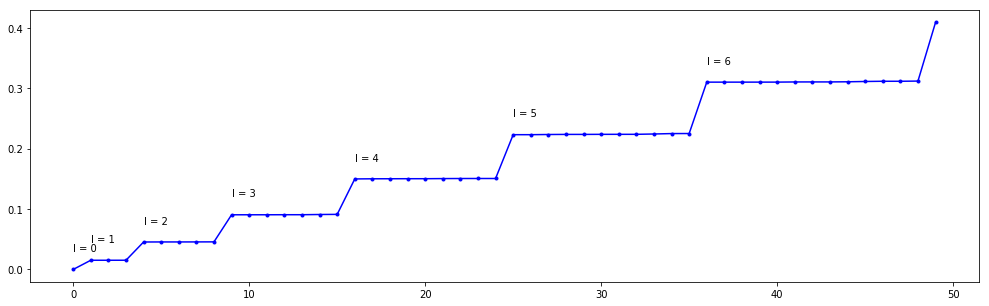

In [6]:
plt.plot(deepsphere_thresholded_graphs[-1].e[:50], 'b.')
plt.plot(deepsphere_thresholded_graphs[-1].e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, deepsphere_thresholded_graphs[-1].e[idx**2] + 0.03, 'l = {}'.format(idx));
plt.savefig('deepsphere_thresholded_eigenvalues')

### DeepSphere original construction:

kernel width used:  0.10032392184959485
Number of neighbours:  21.7890625
kernel width used:  0.025613535338057818
Number of neighbours:  21.7890625
kernel width used:  0.006474086576916097
Number of neighbours:  21.7890625


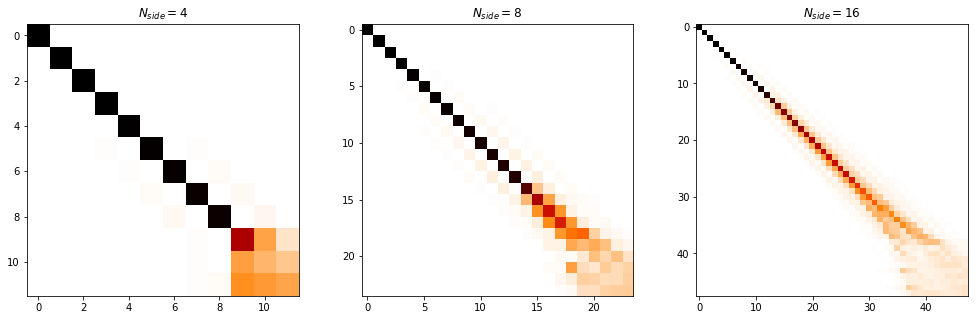

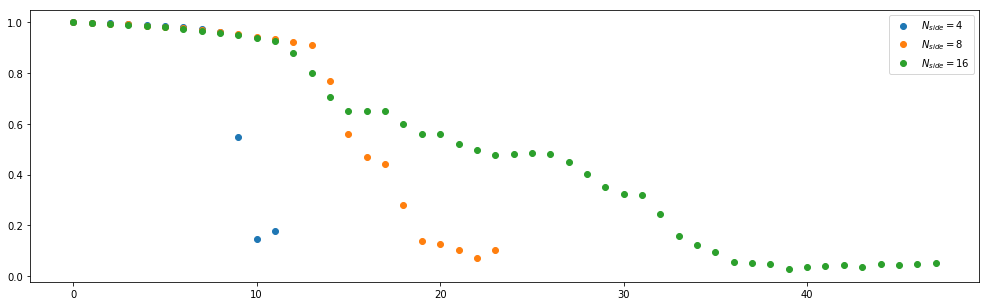

In [4]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [4, 8, 16]
graphs = []
spectral_content = dict()

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, dtype=np.float64, std='kernel_width')  # in NEST order

    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("deepsphere_original.png")
fig2.savefig("deepsphere_original_diagonal.png")

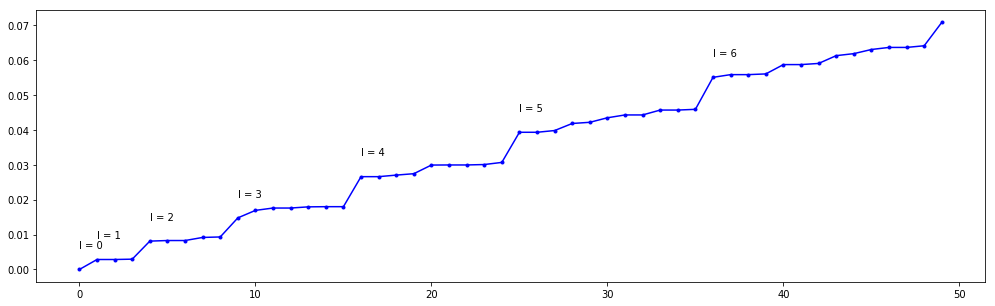

In [11]:
plt.plot(graph.e[:50], 'b.')
plt.plot(graph.e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, graph.e[idx**2] + 0.006, 'l = {}'.format(idx));
plt.savefig('deepsphere_eigenvalues')

### Optimal full construction

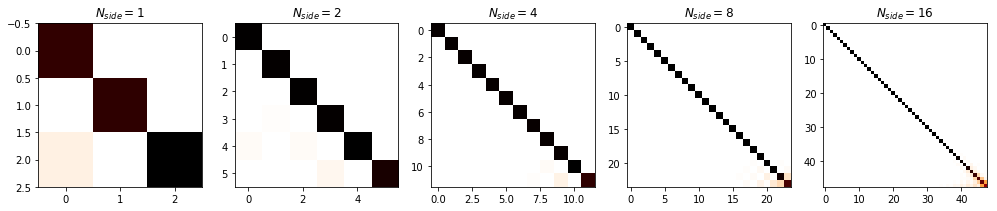

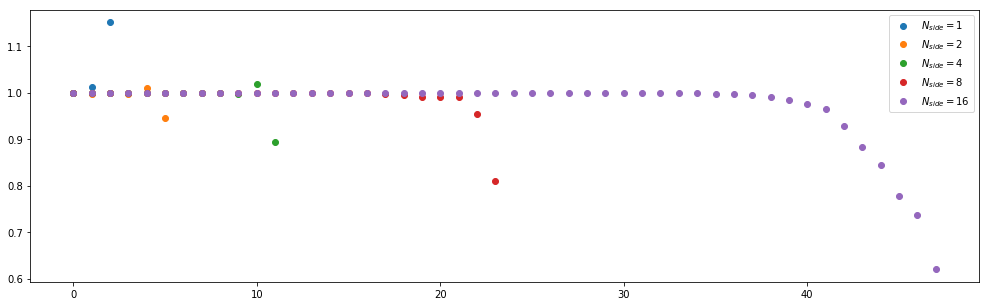

In [10]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [1, 2, 4, 8, 16]
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]

graphs = []
spectral_content = dict()

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("optimal_full.png")
fig2.savefig("optimal_full_diagonal.png")

### Optimal construction thresholded at 0.01

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01
Number of neighbours:  11.0
Threshold:  0.01
Number of neighbours:  16.833333333333332
Threshold:  0.01
Number of neighbours:  37.708333333333336
Threshold:  0.01
Number of neighbours:  43.510416666666664
Threshold:  0.01
Number of neighbours:  52.6171875


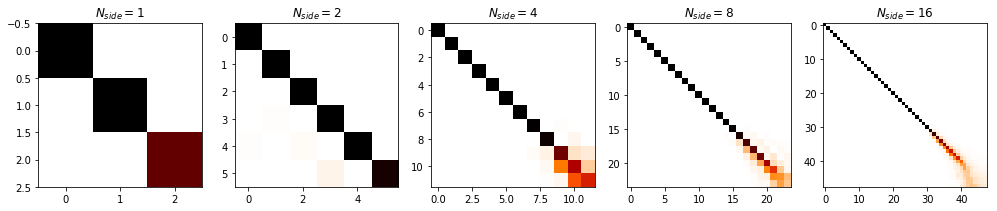

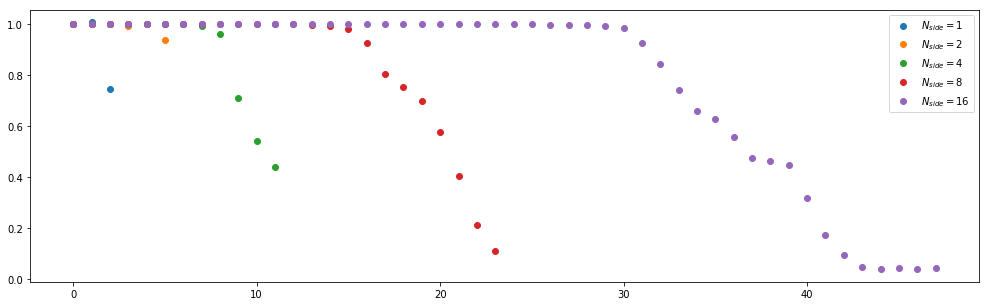

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [1, 2, 4, 8, 16]
sigmas = [1, 0.3, 0.175, 0.0525, 0.015]

thresholded_graphs = []
spectral_content = dict()

k = 0.01

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    thresholded_graphs.append(pg.graphs.Graph(W))
    graph = thresholded_graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("optimal_thresholded.png")
fig2.savefig("optimal_thresholded_diagonal.png")

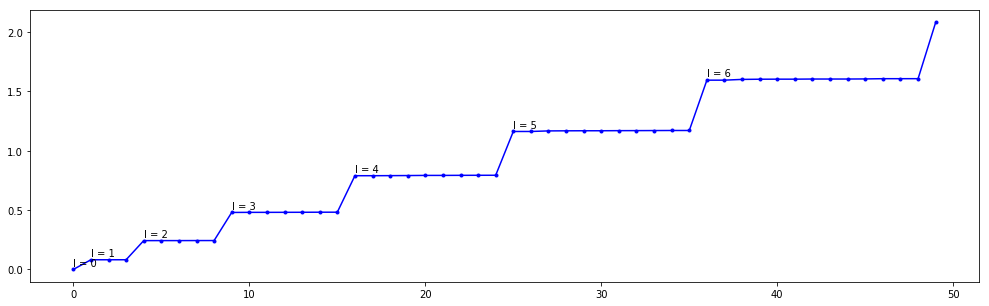

In [16]:
plt.plot(thresholded_graphs[-1].e[:50], 'b.')
plt.plot(thresholded_graphs[-1].e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, thresholded_graphs[-1].e[idx**2] + 0.03, 'l = {}'.format(idx));
plt.savefig('optimal_thresholded_eigenvalues')

## Sensitivity on $\sigma$

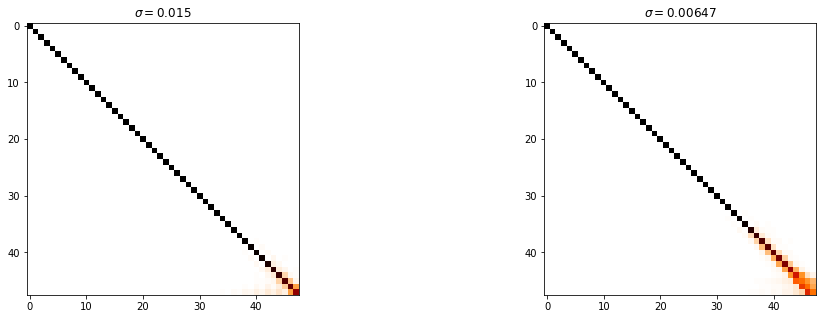

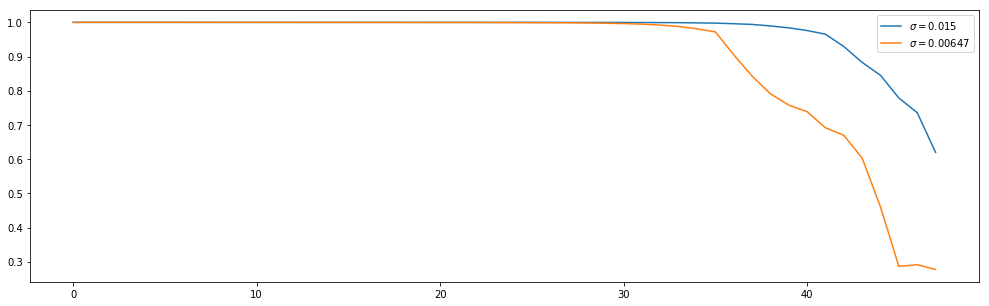

In [13]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = [0.015, 0.00647]
nsides = [16]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    # fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$\sigma={sigma}$')

ax2.legend();
fig1.savefig("t_sesitivity.png")
fig2.savefig("t_sesitivity_diagonal.png")

## tradeoff of high-low frequencies given by Sigma

[0.04, 0.05]


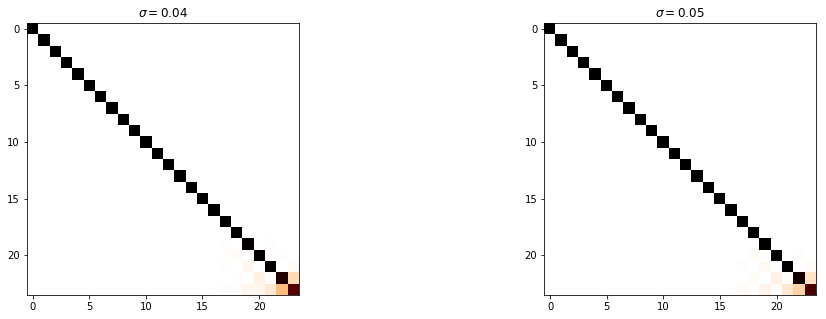

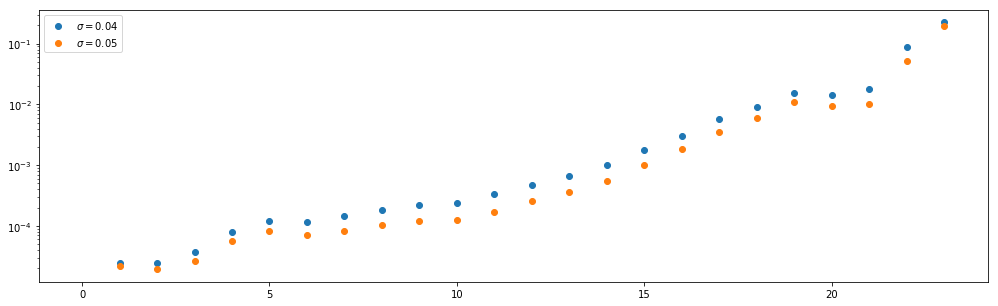

In [16]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = [0.04,0.05]
print(sigmas)
nsides = [8]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    # fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.semilogy(abs(1-energy_in), 'o', label=rf'$\sigma={sigma}$')

ax2.legend();
fig1.savefig("t_sesitivity.png")
fig2.savefig("t_sesitivity_diagonal.png")

[0.01       0.01467799 0.02154435 0.03162278 0.04641589 0.06812921
 0.1        0.14677993 0.21544347 0.31622777]


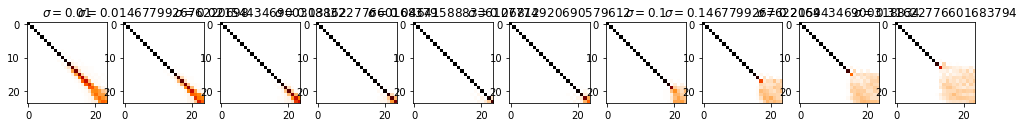

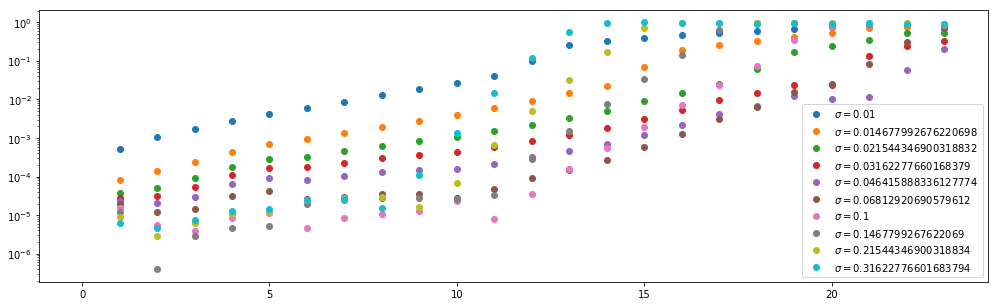

In [12]:
plt.rcParams['figure.figsize'] = (17, 5)
sigmas = np.logspace(-2,-0.5,10)
print(sigmas)
nsides = [8]*len(sigmas)

graphs = []
spectral_content = dict()

for j, (nside, sigma) in enumerate(zip(nsides, sigmas)):
    
    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.full_healpix_graph(nside, dtype=np.float64, std=sigma))
    graph = graphs[-1]
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[sigma] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)a
        spectral_content[sigma][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (sigma, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    # fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$\sigma={sigma}$')

    energy_in = np.diag(sc)
    ax2.semilogy(abs(1-energy_in), 'o', label=rf'$\sigma={sigma}$')

ax2.legend();
fig1.savefig("t_sesitivity.png")
fig2.savefig("t_sesitivity_diagonal.png")

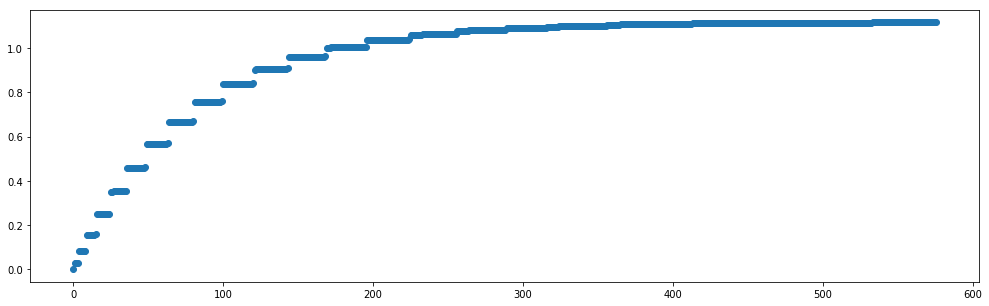

In [17]:
plt.plot(graph.e, 'o')